# Project 1

In [ ]:
import math
import collections

import scipy
from scipy.linalg import expm
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import LFR_benchmark_graph

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.stats import pearsonr
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__


Useful functions

In [2]:
def visualize2(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
        
    labels = G.nodes()
    pos=nx.spring_layout(G)
    
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=700)

    # edges
    nx.draw_networkx_edges(G,pos,
                        width=6,alpha=0.5,edge_color='b',style='dashed')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

    plt.axis('off')
    plt.show() # display


In [3]:
def degree_distribution(G, hist=False):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    
    if hist:
        plt.hist(vk, bins=range(0, maxk+1), normed=True)
        plt.ylabel("Pk", fontsize=15)
        plt.xlabel("Degree", fontsize=15)
        plt.title("Degree distribution", fontsize=20)
        plt.grid(True)
        plt.show(True)
    
    return kvalues, Pk

In [4]:
def draw_centrality_hist(centralities, title="Defaul title", ylabel="Default ylabel", xlabel="Defaul xlabel"):
    """
    centralities = np.array(centralities)
    maxk = np.max(centralities)
    mink = np.min(centralities)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    """
    
    plt.figure(figsize=(6,4))
    #plt.hist(centralities, bins=range(0, maxk+1), normed=True)
    plt.hist(centralities, density=True)
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show(True)

In [5]:
def acc(G):
    N = len(G.nodes)
    vk = dict(G.degree())
    vk = list(vk.values())
    A = nx.adjacency_matrix(G)
    P = np.zeros((N,N), dtype = 'float')
    for i in np.arange(0, N):
        for j in np.arange(0, N):
            if(vk[i] > 0):
                P[i,j] = A[i,j]/vk[i]
    P2 = expm(P)/np.exp(1)
    vacc = np.zeros(N, dtype = float)
    for i in np.arange(0, N):
        acc = 0
        for j in np.arange(0,N):
            if(P2[i,j] > 0):
                acc = acc + P2[i,j]*np.log(P2[i,j])
        acc = np.exp(-acc)
        vacc[i] = acc
    return vacc

In [6]:
def calc_knn(graph):
    knn = []
    for i in graph.nodes():
        aux =  nx.average_neighbor_degree(graph, nodes = [i])
        knn.append(float(aux[i]))
    return np.array(knn) 

In [7]:
def calc_knn_k(vk, knn, plot=False):
    knnk = list()
    ks = list()
    for k in np.arange(np.min(vk), np.max(vk)):
        aux = vk == k
        if(len(knn[aux]) > 0):
            av_knn = np.mean(knn[aux]) #average clustering among all the nodes with degree k
            knnk.append(av_knn)
            ks.append(k)
            
    if plot:
        plt.plot(ks, knnk, 'ro')
        #plt.loglog(ks,knnk,'bo',basex=10,basey=10)
        #plt.title("Average neighborhood connectivity vs degree")
        plt.ylabel("knn(k)")
        plt.xlabel("k")
        plt.grid(True)
        plt.savefig('knnk.eps')

        # determine best fit line
        par = np.polyfit(ks, knnk, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        xl = [min(ks), max(ks)]
        yl = [slope*xx + intercept  for xx in xl]
        plt.plot(xl, yl, '-b')
        plt.savefig('knn.eps') #save the figure into a file
        plt.show(True)
        
    return ks, knn

Load necessary datasets into all_graphs

In [8]:
# Read all the data we will use now and in the future
all_graphs = {}
all_graphs["E-road"] = nx.read_edgelist("data/euroroad.txt")

all_graphs["Proteins"] = nx.read_edgelist("data/out.proteins", comments="%")

all_graphs["Hamster"] = nx.read_edgelist("data/out.petster-friendships-hamster-uniq", comments="%")

all_graphs["C Elegans 2004"] = nx.read_edgelist("data/wi2004.txt", comments="#")
all_graphs["C Elegans 2007"] = nx.read_edgelist("data/wi2007.txt", comments="#")

all_graphs["US Power Grid"] = nx.read_gml("data/uspowergrid.gml", label="id")

all_graphs["C elegans"] = nx.MultiGraph()
all_graphs["C elegans"] = nx.read_gml("data/celegansneural.gml")
all_graphs["C elegans"] = nx.Graph(all_graphs["C elegans"])
all_graphs["C elegans"] = nx.convert_node_labels_to_integers(all_graphs["C elegans"], first_label=0)

all_graphs["US Airports"] = nx.Graph()
all_graphs["US Airports"] = nx.read_edgelist("data/USairport500.txt", nodetype=int, data=(('weight',float),))

# Read from csv file
df = pd.read_csv('data/rdependencies.csv')
all_graphs["R Dependencies"] = nx.from_pandas_edgelist(df, source="from", target="to", edge_attr=None)

# Cities' networks
all_graphs["Motuca"] = ox.graph_from_place('Motuca', network_type='drive', simplify=False)
all_graphs["Mombuca"] = ox.graph_from_place('Mombuca', network_type='drive', simplify=False)
all_graphs["Guatapara"] = ox.graph_from_place('Guatapara', network_type='drive', simplify=False)
all_graphs["Rincao"] = ox.graph_from_place('Rincao', network_type='drive', simplify=False)

# Convert data to undirected and remove loops
for graph in all_graphs.keys():
    all_graphs[graph] = all_graphs[graph].to_undirected()
    if graph != "R Dependencies":
          all_graphs[graph].remove_edges_from(nx.selfloop_edges(all_graphs[graph]))

# Q1

In [9]:
def q1centralities(net):
    centralities = {}
    centralities["Degree"] = list(dict(all_graphs[net].degree()).values())
    centralities["K-Core"] = list(dict(nx.core_number(all_graphs[net])).values())
    centralities["Closeness"] = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    centralities["Betweenness"] = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    centralities["Eigenvector"] = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    centralities["Pagerank"] = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    centralities["Accessibility"] = acc(all_graphs[net])
    #centralities["Communicability"] = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
    # TODO: USAR ACIMA
        
    return centralities
        

In [10]:
def correlationMatrix(centralities):
    df = pd.DataFrame(centralities)
    corr = df.corr()
    plt.figure(figsize=(8,8))
    plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical', fontsize=20)
    plt.yticks(range(len(corr)), corr.columns, fontsize=20);
    plt.suptitle('Correlation between centrality measures', fontsize=20)
    plt.grid(False)
    plt.show()

==================================== E-road Correlation Matrix ====================================


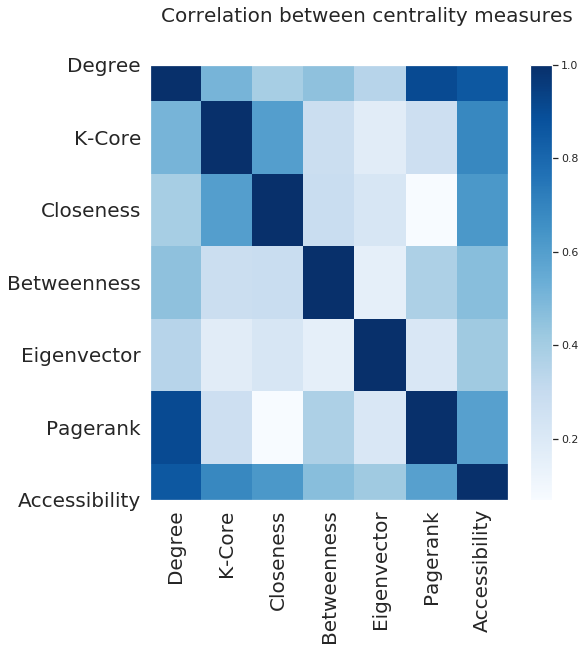

In [11]:
# q1nets = ["E-road", "Hamster", "C elegans", "US Airports"]
q1nets = ["E-road"] # TODO: USAR ACIMA

for net in q1nets:
    print("==================================== " + net + " Correlation Matrix ====================================")
    correlationMatrix(q1centralities(net))

# Q2

## I) Motuca

### Degree

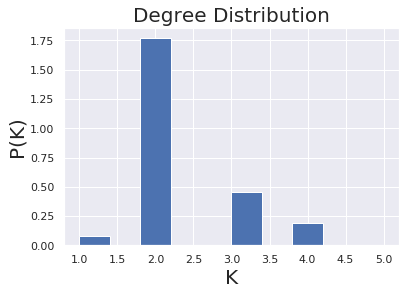

In [12]:
vk = list(dict(all_graphs["Motuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

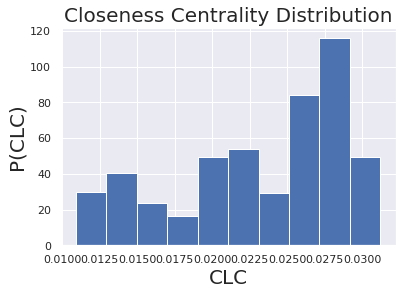

In [13]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

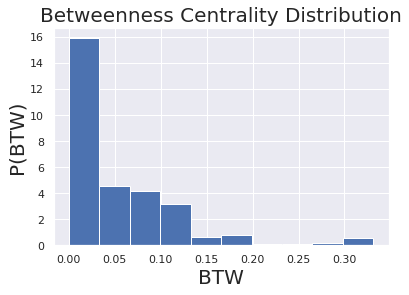

In [14]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Motuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## II) Mombuca

### Degree

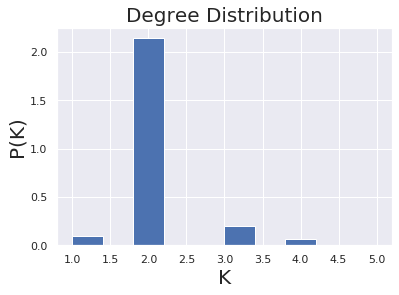

In [15]:
vk = list(dict(all_graphs["Mombuca"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

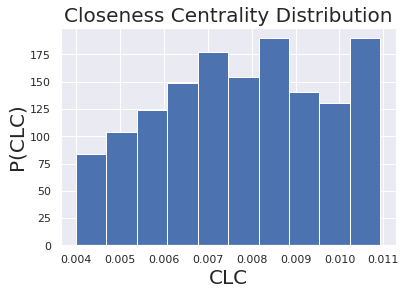

In [16]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

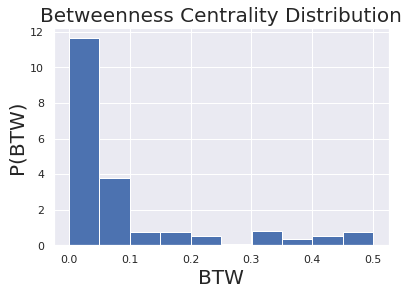

In [17]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Mombuca"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## III) Guatapara

### Degree

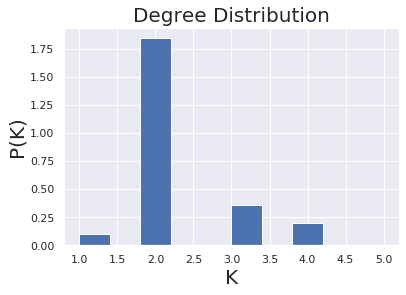

In [18]:
vk = list(dict(all_graphs["Guatapara"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

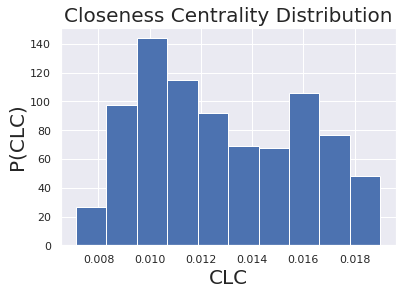

In [19]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

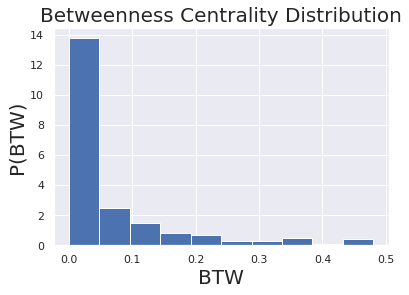

In [20]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Guatapara"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

## IV) Rincão

### Degree

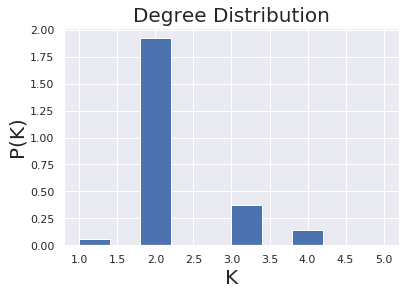

In [21]:
vk = list(dict(all_graphs["Rincao"].degree()).values())

draw_centrality_hist(vk, title="Degree Distribution", ylabel="P(K)", xlabel="K")

### Closeness Centrality

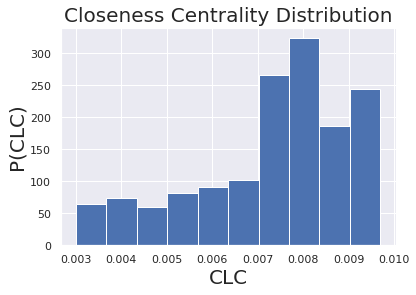

In [22]:
CLC = list(dict(nx.closeness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(CLC, title="Closeness Centrality Distribution", ylabel="P(CLC)", xlabel="CLC")

### Betweeness Centrality

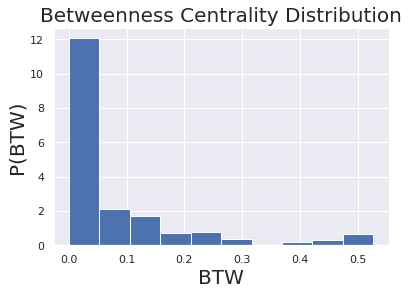

In [23]:
BTW = list(dict(nx.betweenness_centrality(all_graphs["Rincao"])).values())

draw_centrality_hist(BTW, title="Betweenness Centrality Distribution", ylabel="P(BTW)", xlabel="BTW")

TODO: Interpretação dos resultados (placeholder)

# Q3

In [24]:
def q3centralities(nets):
    for net in nets:
        print("=============== " + net + " ===============")
        
        degree_cent = list(dict(all_graphs[net].degree()).values())
        draw_centrality_hist(degree_cent, title="Degree Centrality Histogram", ylabel="P(K)", xlabel="K")
        
        closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
        draw_centrality_hist(closeness_cent, title="Closeness Centrality Histogram", ylabel="P(CLC)", xlabel="CLC")
        
        eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
        draw_centrality_hist(eigenvector_cent, title="Eigenvector Centrality Histogram", ylabel="P(EC)", xlabel="EC")
        
        pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
        draw_centrality_hist(pagerank_cent, title="Pagerank Centrality Histogram", ylabel="P(PR)", xlabel="PR")

=============== C Elegans 2004 ===============


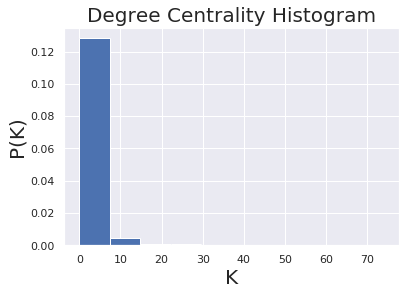

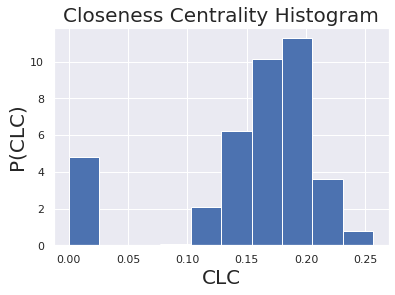

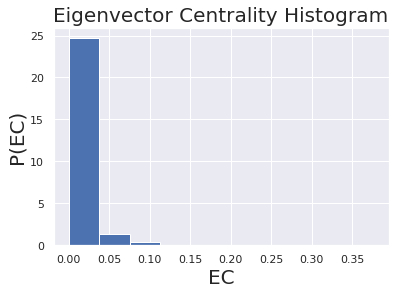

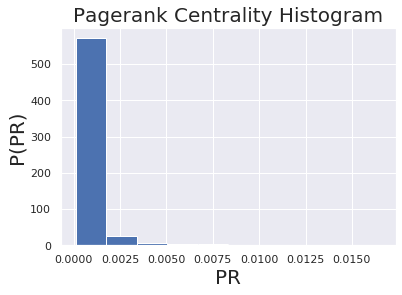

In [25]:
# q3nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]    
q3nets = ["C Elegans 2004"]    # TODO: usar a linha de cima (demora) e deixar bonito
q3centralities(q3nets)

TODO: interpretar resultados

# Q4

In [26]:
def q4centralities(net):
    degree_cent = list(dict(all_graphs[net].degree()).values())
    kcore_cent = list(dict(nx.core_number(all_graphs[net])).values())
    closeness_cent = list(dict(nx.closeness_centrality(all_graphs[net])).values())
    betweenness_cent = list(dict(nx.betweenness_centrality(all_graphs[net])).values())
    eigenvector_cent = list(dict(nx.eigenvector_centrality(all_graphs[net], max_iter = 1000)).values())
    pagerank_cent = list(dict(nx.pagerank(all_graphs[net], alpha=0.85)).values())
    accessibility_cent = acc(all_graphs[net])
    communicability_cent = list(dict(nx.communicability_betweenness_centrality(all_graphs[net])).values())
        
    return [degree_cent, kcore_cent, closeness_cent, betweenness_cent, eigenvector_cent, pagerank_cent,
           accessibility_cent, communicability_cent]
        

In [27]:
def q4measures(centralities):
    measures = []
    
    for centralitiy in centralities:
        average = np.mean(centrality)
        standard_deviation = np.std(centrality)
        second_moment = scipy.stats.moment(centrality, moment=2)
        shannon_entropy = scipy.stats.entropy(centrality)
        measures.append([average, standard_deviation, second_moment, shannon_entropy])
        
    return measures.flatten()

In [ ]:
# q4nets = ["Proteins", "C Elegans 2004", "C Elegans 2007", "US Power Grid"]
q4nets = ["Proteins"] # TODO: USAR ACIMA

features = []
for net in q4nets:
    features.append(q4measures(q4centralities(net)))

/usr/lib/python3.7/site-packages/networkx/algorithms/centrality/subgraph_alg.py:246: RuntimeWarning: invalid value encountered in true_divide
  B = (expA - scipy.linalg.expm(A.A)) / expA


TODO: fazer o PCA

# Q5

In [ ]:
def q5correlations(graph):
    # First calculate knn
    knn = calc_knn(graph)
    
    # Now calculate vk
    vk = dict(graph.degree())
    vk = list(vk.values())
    
    # From knn and vk, calculate ks and knn(k)
    ks, knnk = calc_knn_k(vk, knn, plot=True) # also, plot the scatter graph
    
    # Pearson correlation coefficient
    rho = np.corrcoef(ks, knnk)[0,1]
    print('Pearson correlation coefficient:', rho)
    r = nx.degree_assortativity_coefficient(graph)
    print("Assortativity coefficient:", r)


In [ ]:
# q5nets = ["E-road", "C elegans", "US Airports", "Proteins"]
q5nets = ["E-road"] # TODO: Usar a linha acima

for net in q5nets:
    q5correlations(all_graphs[net])

TODO: fix and interpret results

# Q6

In [ ]:
N = 128
k = 16
G = LFR_benchmark_graph(n = N, min_degree = 16, max_degree = 16, min_community=minc, max_community = maxc, seed = 10)

In [ ]:
#Girvan-Newman method (betweenness centrality)
communities = community.girvan_newman(G)
k = 4
for i in arange(0, k-1):
    next_level_communities = next(communities)
c = sorted(map(sorted, next_level_communities))
for cl in c:
    print('community:', cl)